# Ch2 Lecture 1

# *Reaction-Diffusion Equations*

## *Diffusion*

Adapted from [this blog
post](http://www.degeneratestate.org/posts/2017/May/05/turing-patterns/).

Last week, we talked about the **diffusion equation**. Here is the exact
form:

$$\frac{\partial a(x,t)}{\partial t} = D_{a}\frac{\partial^{2} a(x,t)}{\partial x^{2}}$$

. . .

We approximated this using [the finite-difference
method](https://en.wikipedia.org/wiki/Finite_difference_method#Example:_The_heat_equation):

Time derivative (which we had set to zero):

$$
\frac{\partial a(x,t)}{\partial t} \approx \frac{1}{dt}(a_{x,t+1} - a_{x,t})
$$

Spacial part of the derivative (which is usually know as the
[Laplacian](https://en.wikipedia.org/wiki/Laplace_operator)):

$$
\frac{\partial^{2} a(x,t)}{\partial x^{2}} \approx \frac{1}{dx^{2}}(a_{x+1,t} + a_{x-1,t} - 2a_{x,t})
$$

. . .

This gives us the finite-difference equation:

$$
a_{x,t+1} = a_{x,t} + dt\left(  \frac{D_{a}}{dx^{2}}(a_{x+1,t} + a_{x-1,t} - 2a_{x,t})  \right)
$$

## *Boundary Conditions*

-   Last week, with our metal rod, we had **boundary conditions** where
    the temperatures at the ends of the rod were fixed at 0 degrees.

-   We needed to say *something* about the boundaries to solve the
    system of equations.

-   Another option is **periodic boundary conditions**.

-   These are like imagining the rod is a loop, so the temperature at
    the end of the rod is the same as the temperature at the beginning
    of the rod.

## *Periodic Boundary Conditions: np.roll*

-   Want an easy way to compute $a_{x+1}$ for all $x$’s

-   Suppose we have n points, and we want to compute $a_{x+1}$ for all
    $x$=n.

-   Problem: $a_{x+1}$ would be off the end of the array!

-   Just replace $a_{n+1}$ with $a_{1}$

-   Can do this easily with `np.roll`. Lets us compute $a_{x+1}$ for all
    $x$’s.

. . .

``` {pyodide-python}
import numpy as np
a = np.arange(10)
a
np.roll(a, -1)
```

## *Laplacian with Periodic Boundary Conditions in Python*

In [2]:
import numpy as np
def laplacian1D(a, dx):
    return (
        - 2 * a
        + np.roll(a,1,axis=0)
        + np.roll(a,-1,axis=0)
    ) / (dx ** 2)

def laplacian2D(a, dx):
    return (
        - 4 * a
        + np.roll(a,1,axis=0)
        + np.roll(a,-1,axis=0)
        + np.roll(a,+1,axis=1)
        + np.roll(a,-1,axis=1)
    ) / (dx ** 2)

In [3]:
"""
Some utility functions for blog post on Turing Patterns.
"""

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

class BaseStateSystem:
    """
    Base object for "State System".

    We are going to repeatedly visualise systems which are Markovian:
    the have a "state", the state evolves in discrete steps, and the next
    state only depends on the previous state.

    To make things simple, I'm going to use this class as an interface.
    """
    def __init__(self):
        raise NotImplementedError()

    def initialise(self):
        raise NotImplementedError()

    def initialise_figure(self):
        fig, ax = plt.subplots()
        return fig, ax

    def update(self):
        raise NotImplementedError()

    def draw(self, ax):
        raise NotImplementedError()

    def plot_time_evolution(self, filename, n_steps=30):
        """
        Creates a gif from the time evolution of a basic state syste.
        """
        self.initialise()
        fig, ax = self.initialise_figure()

        def step(t):
            self.update()
            self.draw(ax)

        anim = animation.FuncAnimation(fig, step, frames=np.arange(n_steps), interval=20)
        anim.save(filename=filename, dpi=60, fps=10, writer='imagemagick')
        plt.close()
        
    def plot_evolution_outcome(self, filename, n_steps):
        """
        Evolves and save the outcome of evolving the system for n_steps
        """
        self.initialise()
        fig, ax = self.initialise_figure()
        
        for _ in range(n_steps):
            self.update()

        self.draw(ax)
        fig.savefig(filename)
        plt.close()

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# I'm using seaborn for it's fantastic default styles
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2

## *Solving and animating*

In [5]:
class OneDimensionalDiffusionEquation(BaseStateSystem):
    def __init__(self, D):
        self.D = D
        self.width = 1000
        self.dx = 10 / self.width
        self.dt = 0.9 * (self.dx ** 2) / (2 * D)
        self.steps = int(0.1 / self.dt)

    def initialise(self):
        self.t = 0
        self.X = np.linspace(-5,5,self.width)
        self.a = np.exp(-self.X**2)

    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        La = laplacian1D(self.a, self.dx)
        delta_a = self.dt * (self.D * La)
        self.a += delta_a

    def draw(self, ax):
        ax.clear()
        ax.plot(self.X,self.a, color="r")
        ax.set_ylim(0,1)
        ax.set_xlim(-5,5)
        ax.set_title("t = {:.2f}".format(self.t))

one_d_diffusion = OneDimensionalDiffusionEquation(D=1)

one_d_diffusion.plot_time_evolution("diffusion.gif")

MovieWriter imagemagick unavailable; using Pillow instead.

<figure>
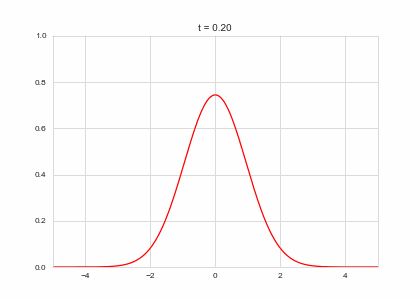
<figcaption aria-hidden="true">diffusion.gif</figcaption>
</figure>

## *Reaction Terms*

-   We will have a system with **two** chemical components, $a$ and $b$.

-   Suppose $a$ activates genes which produce pigmentation. $b$ inhibits
    $a$

-   Will start with some random small initial concentrations of $a$ and
    $b$.

-   Each will diffuse according to the diffusion equation.

-   They will also react with each other, changing the concentration of
    each.

. . .

For the reaction equations, will use the [FitzHugh–Nagumo
equation](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model)

$R_a(a, b) = a - a^{3} - b + \alpha$

$R_{b}(a, b) = \beta (a - b)$

Where $\alpha$ and $\beta$ are constants.

## *Reaction Equation evolution at one point in space*

In [6]:
class ReactionEquation(BaseStateSystem):
    def __init__(self, Ra, Rb):
        self.Ra = Ra
        self.Rb = Rb
        self.dt = 0.01
        self.steps = int(0.1 / self.dt)

    def initialise(self):
        self.t = 0
        self.a = 0.1
        self.b = 0.7
        self.Ya = []
        self.Yb = []
        self.X = []

    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        delta_a = self.dt * self.Ra(self.a,self.b)
        delta_b = self.dt * self.Rb(self.a,self.b)

        self.a += delta_a
        self.b += delta_b

    def draw(self, ax):
        ax.clear()

        self.X.append(self.t)
        self.Ya.append(self.a)
        self.Yb.append(self.b)

        ax.plot(self.X,self.Ya, color="r", label="A")
        ax.plot(self.X,self.Yb, color="b", label="B")
        ax.legend()

        ax.set_ylim(0,1)
        ax.set_xlim(0,5)
        ax.set_xlabel("t")
        ax.set_ylabel("Concentrations")

alpha, beta =  0.2, 5

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

one_d_reaction = ReactionEquation(Ra, Rb)
one_d_reaction.plot_time_evolution("reaction.gif", n_steps=50)

MovieWriter imagemagick unavailable; using Pillow instead.

## 

<figure>
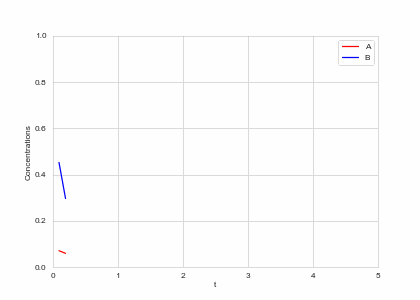
<figcaption aria-hidden="true">reaction.gif</figcaption>
</figure>

## *Full Model*

We now have two parts: - a diffusion term that “spreads” out
concentration - a reaction part the equalises the two concentrations. .
. .

What happens when we put the two together? Do we get something stable?

##

In [7]:
def random_initialiser(shape):
    return(
        np.random.normal(loc=0, scale=0.05, size=shape),
        np.random.normal(loc=0, scale=0.05, size=shape)
    )

class OneDimensionalRDEquations(BaseStateSystem):
    def __init__(self, Da, Db, Ra, Rb,
                 initialiser=random_initialiser,
                 width=1000, dx=1,
                 dt=0.1, steps=1):

        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb

        self.initialiser = initialiser
        self.width = width
        self.dx = dx
        self.dt = dt
        self.steps = steps

    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.width)

    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):

        # unpack so we don't have to keep writing "self"
        a,b,Da,Db,Ra,Rb,dt,dx = (
            self.a, self.b,
            self.Da, self.Db,
            self.Ra, self.Rb,
            self.dt, self.dx
        )

        La = laplacian1D(a, dx)
        Lb = laplacian1D(b, dx)

        delta_a = dt * (Da * La + Ra(a,b))
        delta_b = dt * (Db * Lb + Rb(a,b))

        self.a += delta_a
        self.b += delta_b

    def draw(self, ax):
        ax.clear()
        ax.plot(self.a, color="r", label="A")
        ax.plot(self.b, color="b", label="B")
        ax.legend()
        ax.set_ylim(-1,1)
        ax.set_title("t = {:.2f}".format(self.t))

Da, Db, alpha, beta = 1, 100, -0.005, 10

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

OneDimensionalRDEquations(
    Da, Db, Ra, Rb,
    width=width, dx=dx, dt=dt,
    steps=100
).plot_time_evolution("1dRD.gif", n_steps=150)

MovieWriter imagemagick unavailable; using Pillow instead.

## 

<figure>
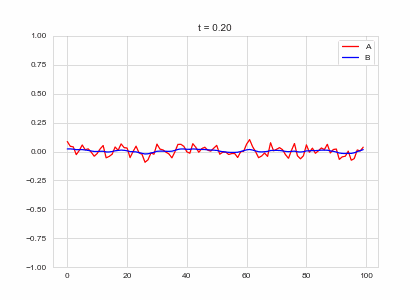
<figcaption aria-hidden="true">1dRD.gif</figcaption>
</figure>

## *In two dimensions*

In [8]:
class TwoDimensionalRDEquations(BaseStateSystem):
    def __init__(self, Da, Db, Ra, Rb,
                 initialiser=random_initialiser,
                 width=1000, height=1000,
                 dx=1, dt=0.1, steps=1):

        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb

        self.initialiser = initialiser
        self.width = width
        self.height = height
        self.shape = (width, height)
        self.dx = dx
        self.dt = dt
        self.steps = steps

    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.shape)

    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):

        # unpack so we don't have to keep writing "self"
        a,b,Da,Db,Ra,Rb,dt,dx = (
            self.a, self.b,
            self.Da, self.Db,
            self.Ra, self.Rb,
            self.dt, self.dx
        )

        La = laplacian2D(a, dx)
        Lb = laplacian2D(b, dx)

        delta_a = dt * (Da * La + Ra(a,b))
        delta_b = dt * (Db * Lb + Rb(a,b))

        self.a += delta_a
        self.b += delta_b

    def draw(self, ax):
        ax[0].clear()
        ax[1].clear()

        ax[0].imshow(self.a, cmap='jet')
        ax[1].imshow(self.b, cmap='brg')

        ax[0].grid(visible=False)
        ax[1].grid(visible=False)

        ax[0].set_title("A, t = {:.2f}".format(self.t))
        ax[1].set_title("B, t = {:.2f}".format(self.t))

    def initialise_figure(self):
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        return fig, ax

Da, Db, alpha, beta = 1, 100, -0.015, 10

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

TwoDimensionalRDEquations(
    Da, Db, Ra, Rb,
    width=width, height=width,
    dx=dx, dt=dt, steps=100
).plot_evolution_outcome("2dRD.png", n_steps=150)

<figure>
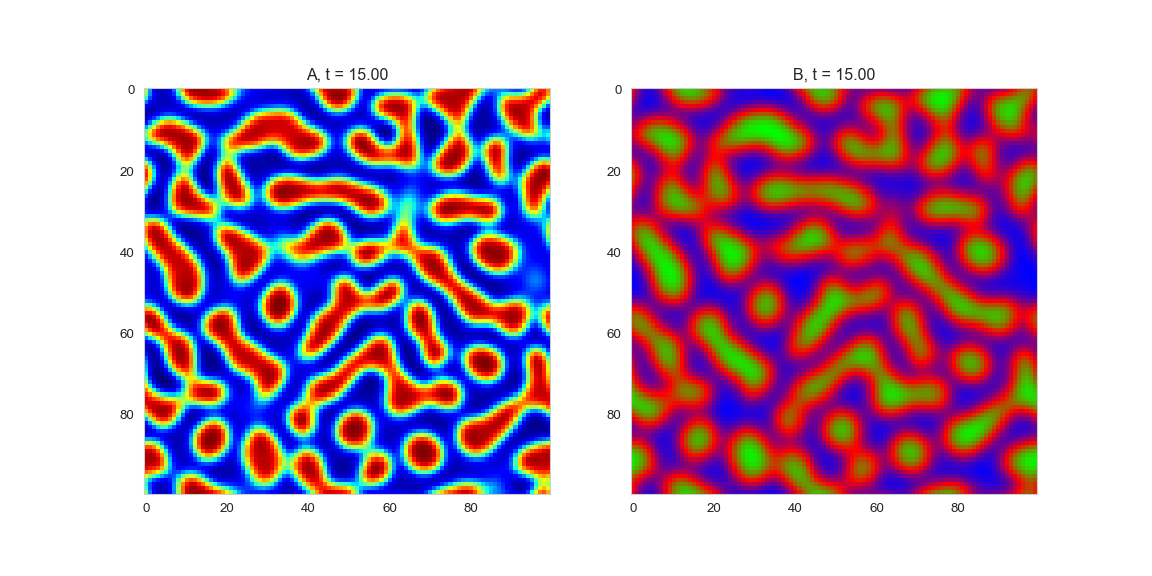
<figcaption aria-hidden="true">2dRD.png</figcaption>
</figure>

# *Review of Matrix Arithmetic*

## *Matrix Addition and Subtraction*

Review matrix addition and subtraction on your own!

## *Matrix Multiplication*

For motivation:

$$
2 x-3 y+4 z=5 \text {. }
$$

-   Can write as a “product” of the coefficient matrix $[2,-3,4]$ and
    and the column matrix of unknowns
    $\left[\begin{array}{l}x \\ y \\ z\end{array}\right]$.

. . .

Thus, product is:

$$
[2,-3,4]\left[\begin{array}{l}
x \\
y \\
z
\end{array}\right]=[2 x-3 y+4 z]
$$

## *Definition of matrix product*

$A=\left[a_{i j}\right]$: $m \times p$ matrix

$B=\left[b_{i j}\right]$: $p \times n$ matrix.

Product of $A$ and $B$ – $A B$

-   is $m \times n$ matrix whose
-   $(i, j)$ th entry is the entry of the product of the $i$ th row of
    $A$ and the $j$ th column of $B$;

. . .

More specifically, the $(i, j)$ th entry of $A B$ is

$$
a_{i 1} b_{1 j}+a_{i 2} b_{2 j}+\cdots+a_{i p} b_{p j} .
$$

**Reminder**: Matrix Multiplication is not Commutative

-   $A B \neq B A$ in general.

## *Linear Systems as a Matrix Product*

We can express a linear system of equations as a matrix product:

$$
\begin{aligned}
x_{1}+x_{2}+x_{3} & =4 \\
2 x_{1}+2 x_{2}+5 x_{3} & =11 \\
4 x_{1}+6 x_{2}+8 x_{3} & =24
\end{aligned}
$$

. . .

$$
\mathbf{x}=\left[\begin{array}{l}
x_{1} \\
x_{2} \\
x_{3}
\end{array}\right], \quad \mathbf{b}=\left[\begin{array}{r}
4 \\
11 \\
24
\end{array}\right], \quad \text { and } A=\left[\begin{array}{lll}
1 & 1 & 1 \\
2 & 2 & 5 \\
4 & 6 & 8
\end{array}\right]
$$

. . .

$$
A \mathbf{x}=\left[\begin{array}{lll}
1 & 1 & 1 \\
2 & 2 & 5 \\
4 & 6 & 8
\end{array}\right]\left[\begin{array}{l}
x_{1} \\
x_{2} \\
x_{3}
\end{array}\right]=\left[\begin{array}{r}
4 \\
11 \\
24
\end{array}\right]=\mathbf{b}
$$

## *Matrix Multiplication as a Linear Combination of Column Vectors*

Another way of writing this system:

$$
x_{1}\left[\begin{array}{l}
1 \\
2 \\
4
\end{array}\right]+x_{2}\left[\begin{array}{l}
1 \\
2 \\
6
\end{array}\right]+x_{3}\left[\begin{array}{l}
1 \\
5 \\
8
\end{array}\right]=\left[\begin{array}{r}
4 \\
11 \\
24
\end{array}\right] .
$$

. . .

Name the columns of A as $\mathbf{a_1}, \mathbf{a_2}, \mathbf{a_3}$,
then we can write the matrix as
$A=\left[\mathbf{a}_{1}, \mathbf{a}_{2}, \mathbf{a}_{3}\right]$

. . .

Let $\mathbf{x}=\left(x_{1}, x_{2}, x_{3}\right)$. Then

$$
A \mathbf{x}=x_{1} \mathbf{a}_{1}+x_{2} \mathbf{a}_{2}+x_{3} \mathbf{a}_{3} .
$$

**This is a very important way of thinking about matrix multiplication**

## *Try it yourself*

Try to find the solution for the following system, by trying different
values of $x_i$ to use in a sum of the columns of $A$.

$$ A \mathbf{x} = \left[\begin{array}{lll}   1 & 1 & 1 \\   2 & 2 & 5 \\   4 & 6 & 8 \end{array}\right]\left[\begin{array}{l} x_1 \\ x_2 \\ x_3 \end{array}\right]=x_{1} \mathbf{a}_{1}+x_{2} \mathbf{a}_{2}+x_{3} \mathbf{a}_{3} =\left[\begin{array}{l} 6 \\ 21 \\ 38 \end{array}\right] 
$$

``` {pyodide-python}
import sympy as sym
A = sym.Matrix([[1, 1, 1], [2, 2, 5], [4, 6, 8]])
a1 = A[:,0]
a2 = A[:,1]
a3 = A[:,2]
# Fill in your guesses for values of x1, x2, and x3
__*a1 + __*a2+__*a3
```

. . .

Now try changing the right-hand side to a different vector. Can you
still find a solution? (You may need to use non-integer values for the
$x$’s.)

## 

This is a slightly changed system.

$$ A \mathbf{x} = \left[\begin{array}{lll}   1 & 1 & 2 \\   1 & 2 & 2 \\   4 & 6 & 8 \end{array}\right]\left[\begin{array}{l} x_1 \\ x_2 \\ x_3 \end{array}\right]=x_{1} \mathbf{a}_{1}+x_{2} \mathbf{a}_{2}+x_{3} \mathbf{a}_{3} =\left[\begin{array}{l} 11 \\ 12 \\ 46 \end{array}\right] 
$$

``` {pyodide-python}
import sympy as sym
A = sym.Matrix([[1, 1, 2], [1, 2, 2], [4, 6, 8]])
a1 = A[:,0]
a2 = A[:,1]
a3 = A[:,2]
# Fill in your guesses for values of x1, x2, and x3
__*a1 + __*a2+__*a3
```

. . .

Are you able to find more than one solution? Can you find a
right-hand-side that *doesn’t* have a solution?

## *Example: Benzoic acid*

Benzoic acid (chemical formula
$\mathrm{C}_{7} \mathrm{H}_{6} \mathrm{O}_{2}$ ) oxidizes to carbon
dioxide and water.

$$
\mathrm{C}_{7} \mathrm{H}_{6} \mathrm{O}_{2}+\mathrm{O}_{2} \rightarrow \mathrm{CO}_{2}+\mathrm{H}_{2} \mathrm{O} .
$$

Balance this equation. (Make the number of atoms of each element match
on the two sides of the equation.)

. . .

Define $(c, o, h)$ as the number of atoms of carbon, oxygen, and
hydrogen atoms in the equation.

. . .

Next let $x_1$, $x_2$, $x_3$, and $x_4$ be the number of molecules of
benzoic acid, oxygen, carbon dioxide, and water, respectively.

. . .

Then we have the equation

$$
x_{1}\left[\begin{array}{l}
7 \\
2 \\
6
\end{array}\right]+x_{2}\left[\begin{array}{l}
0 \\
2 \\
0
\end{array}\right]=x_{3}\left[\begin{array}{l}
1 \\
2 \\
0
\end{array}\right]+x_{4}\left[\begin{array}{l}
0 \\
1 \\
2
\end{array}\right] .
$$

## 

Rearrange:

$$
x_{1}\left[\begin{array}{l}
7 \\
2 \\
6
\end{array}\right]+x_{2}\left[\begin{array}{l}
0 \\
2 \\
0
\end{array}\right]=x_{3}\left[\begin{array}{l}
1 \\
2 \\
0
\end{array}\right]+x_{4}\left[\begin{array}{l}
0 \\
1 \\
2
\end{array}\right] .
$$

becomes

$$
A \mathbf{x}=\left[\begin{array}{cccc}
7 & 0 & -1 & 0 \\
2 & 2 & -2 & -1 \\
6 & 0 & 0 & -2
\end{array}\right]\left[\begin{array}{l}
x_{1} \\
x_{2} \\
x_{3} \\
x_{4}
\end{array}\right]=\left[\begin{array}{l}
0 \\
0 \\
0
\end{array}\right]
$$

## 

We solve with row reduction:

$$
\begin{aligned}
& {\left[\begin{array}{cccc}
7 & 0 & -1 & 0 \\
2 & 2 & -2 & -1 \\
6 & 0 & 0 & -2
\end{array}\right] \xrightarrow[E_{21}\left(-\frac{2}{7}\right)]{E_{31}\left(-\frac{6}{7}\right)}\left[\begin{array}{cccc}
7 & 0 & -1 & 0 \\
0 & 2 & -\frac{12}{7} & -1 \\
0 & 0 & \frac{6}{7} & -2
\end{array}\right] \begin{array}{c}
E_{1}\left(\frac{1}{7}\right) \\
E_{2}\left(\frac{1}{2}\right) \\
E_{3}\left(\frac{7}{6}\right)
\end{array} \left[\begin{array}{cccc}
1 & 0 & -\frac{1}{7} & 0 \\
0 & 1 & -\frac{6}{7} & -\frac{1}{2} \\
0 & 0 & 1 & -\frac{7}{3}
\end{array}\right]} \\
& \begin{array}{l}
\overrightarrow{E_{23}\left(\frac{6}{7}\right)} \\
E_{13}\left(\frac{1}{7}\right)
\end{array}\left[\begin{array}{llll}
1 & 0 & 0 & -\frac{1}{3} \\
0 & 1 & 0 & -\frac{5}{2} \\
0 & 0 & 1 & -\frac{7}{3}
\end{array}\right]
\end{aligned}
$$

. . .

$x_{4}$ is free, others are bound. Now pick smallest $x_4$ where others
are all positive integers…

. . .

$$
2 \mathrm{C}_{7} \mathrm{H}_{6} \mathrm{O}_{2}+15 \mathrm{O}_{2} \rightarrow 14 \mathrm{CO}_{2}+6 \mathrm{H}_{2} \mathrm{O}
$$

# *Matrix Multiplication as a Function*

Every matrix $A$ is associated with a **function** $T_A$ that takes a
vector as input and returns a vector as output.

$$
T_{A}(\mathbf{u})=A \mathbf{u}
$$

. . .

Other names for $T_A$ are “linear transformation” or “linear operator”.

# *Transformations*

## *Scaling*

Goal: Make a matrix that will take a vector of coordinates $\mathbf{x}$
and scale each coordinate $x_i$ by a factor of $z_i$.

$$ A x = \left[\begin{array}{ll} a1 & a2 \\ a3 & a4 \end{array}\right] \left[\begin{array}{l} x_1 \\ x_2 \end{array}\right] = \left[\begin{array}{l} z_1 \times x_1 \\ z_2\times  x_2 \end{array}\right] $$

. . .

$$ A = \left[\begin{array}{ll} z_1 & 0 \\ 0 & z_2 \end{array}\right] $$

## *Shearing*

Shearing: adding a constant shear factor times one coordinate to another
coordinate of the point.

Goal: make a matrix which will transform each coordinate $x_i$ into
$x_i + \sum_{j \ne i} s_{j} \times x_j$.

$$ A x = \left[\begin{array}{ll} a1 & a2 \\ a3 & a4 \end{array}\right] \left[\begin{array}{l} x_1 \\ x_2 \end{array}\right] = \left[\begin{array}{l} x_1 + s_2 x_2 \\ x_2 + s_1 x_1 \end{array}\right] $$

. . .

$$ A = \left[\begin{array}{ll} 1 & s_2 \\ s_1 & 1 \end{array}\right] $$

## *Example*

-   Let the scaling operator $S$ on points in two dimensions have scale
    factors of $\frac{3}{2}$ in the $x$-direction and $\frac{1}{2}$ in
    the $y$-direction.

-   Let the shearing operator $H$ on these points have a shear factor of
    $\frac{1}{2}$ by the $y$-coordinate on the $x$-coordinate.

-   Express these operators as matrix operators and graph their action
    on four unit squares situated diagonally from the origin.

## *Solution*

-   Scaling operator $S$:

. . .

$$
S((x, y))=\left[\begin{array}{c}
\frac{3}{2} x \\
\frac{1}{2} y
\end{array}\right]=\left[\begin{array}{cc}
\frac{3}{2} & 0 \\
0 & \frac{1}{2}
\end{array}\right]\left[\begin{array}{l}
x \\
y
\end{array}\right]=T_{A}((x, y))
$$

. . .

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-098.jpg?height=323&width=366&top_left_y=1248&top_left_x=178)

## *Verify:*

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-098.jpg?height=323&width=366&top_left_y=1248&top_left_x=178)

``` {pyodide-python}
import sympy as sym
S= sym.Matrix([[3/2, 0], [0, 1/2])
point_1 = sym.Matrix([1, 1])
S*point_1
```

## 

-   Shearing operator $H$:

$$
H((x, y))=\left[\begin{array}{c}
x+\frac{1}{2} y \\
y
\end{array}\right]=\left[\begin{array}{ll}
1 & \frac{1}{2} \\
0 & 1
\end{array}\right]\left[\begin{array}{l}
x \\
y
\end{array}\right]=T_{B}((x, y))
$$

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-098.jpg?height=323&width=418&top_left_y=1246&top_left_x=918)

## *Verify*

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-098.jpg?height=323&width=418&top_left_y=1246&top_left_x=918)

``` {pyodide-python}
import sympy as sym
H= sym.Matrix([[1, 1/2], [0, 1])
point_1 = sym.Matrix([1, 1])
H*point_1
```

## *Concatenation of operators $S$ and $H$*

-   The concatenation $S \circ H$ of the scaling operator $S$ and
    shearing operator $H$ is the action of scaling followed by shearing.

-   Function composition corresponds to matrix multiplication

. . .

$$
\begin{aligned}
S \circ H((x, y)) & =T_{A} \circ T_{B}((x, y))=T_{A B}((x, y)) \\
& =\left[\begin{array}{cc}
\frac{3}{2} & 0 \\
0 & \frac{1}{2}
\end{array}\right]\left[\begin{array}{ll}
1 & \frac{1}{2} \\
0 & 1
\end{array}\right]\left[\begin{array}{l}
x \\
y
\end{array}\right]=\left[\begin{array}{cc}
\frac{3}{2} & \frac{3}{4} \\
0 & \frac{1}{2}
\end{array}\right]\left[\begin{array}{l}
x \\
y
\end{array}\right]=T_{C}((x, y)),
\end{aligned}
$$

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-098.jpg?height=323&width=418&top_left_y=1246&top_left_x=918)

## *Verify*

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-098.jpg?height=323&width=418&top_left_y=1246&top_left_x=918)

``` {pyodide-python}
import sympy as sym
C= sym.Matrix([[3/2, 3/4], [0, 1/2])
point_1 = sym.Matrix([1, 1])
C*point_1
```

## *Rotation*

Goal: rotate a point in two dimensions counterclockwise by an angle
$\phi$. Suppose the point is initally at an angle $\theta$ from the
$x$-axis.

![](https://cdn.mathpix.com/cropped/2024_02_16_adbe27593182d62240abg-099.jpg?height=376&width=450&top_left_y=1366&top_left_x=534)

## 

$$
\left[\begin{array}{l}
x \\
y
\end{array}\right]
=\left[\begin{array}{l}
r \cos \theta \\
r \sin \theta
\end{array}\right]
$$

We can use trigonometry to find the values of x and y after rotation.

$$
\left[\begin{array}{l}
x^{\prime} \\
y^{\prime}
\end{array}\right] =\left[\begin{array}{l}
r \cos (\theta+\phi) \\
r \sin (\theta+\phi)
\end{array}\right]=\left[\begin{array}{l}
r \cos \theta \cos \phi-r \sin \theta \sin \phi \\
r \sin \theta \cos \phi+r \cos \theta \sin \phi
\end{array}\right]
$$

. . .

Using the double-angle rule,

$$
 =\left[\begin{array}{rr}
\cos \theta &-\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right]\left[\begin{array}{l}
r \cos \phi \\
r \sin \phi
\end{array}\right]=\left[\begin{array}{rr}
\cos \theta&-\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right]\left[\begin{array}{l}
x \\
y
\end{array}\right]
$$

. . .

So we define the rotation matrix $R(\theta)$ by

$$
R(\theta)=\left[\begin{array}{rr}
\cos \theta & -\sin \theta \\
\sin \theta & \cos \theta
\end{array}\right]
$$

## *Now you try*

``` {pyodide-python}
import matplotlib.pyplot as plt; import matplotlib.patches as mpatches; import sympy as sym;
fig=plt.figure(); plt.clf()
rectangle = sym.Matrix([[0,0],[0,1],[1,1],[1,0]])
A=sym.Matrix([[1,.2],[.2,.2]])
fig, ax = plt.subplots()
ax.add_patch(mpatches.Polygon((A*rectangle.T).T))
ax.add_patch(mpatches.Polygon((rectangle),fc=(1,0,0,0.25)))
automin, automax = plt.xlim(); plt.xlim(automin-0.5, automax+0.5);automin, automax = plt.ylim(); plt.ylim(automin-0.5, automax+0.5)
plt.show()
```